# CS229 Neural Response Forecasting

This project compares how different models may be used for forecasting neural traces data. The dataset used is a calcium imaging dataset of the visual cortext of a rat performing a coherence classification task. The rat is placed in a controlled environment with a screen and three holes placed in a horizontal line, with each hole being roughly the size of its nose. To start the task, the rat needs to poke its nose in the middle hole, at which point the screen in front will show a cluster of dots moving either left or right. A percentage of the dots is moving randomly (either 0, 25, 50, 75, or 100 percent), and once the stimulus ends, the rat needs to poke its nose in either the left or right hole, corresponding to its classification of the stimulus.

## Data Spec

**Neural Traces (`traces`):**
- Each phase contains a `traces` key, which is a list of 2D arrays. Each array represents a single trial.
- The arrays are of shape (157, length_of_trial), where 157 corresponds to the number of neurons imaged, and `length_of_trial` is the number of time points during which the trial was conducted.

**Stimulus Inputs (`u_in`):**
- The `u_in` key within each phase also contains a list of 2D arrays matching the number of trials in `traces`.
- The arrays are of shape (8, length_of_trial), with 8 representing possible stimulus inputs encoded as one-hot vectors.
- Stimuli are categorized by direction and intensity with values from -1 to 1, where negative values denote leftward movement and positive values rightward, and the magnitude represents the fraction of dots moving in that direction.

**Stimulus and Response Periods:**
- Added keys `stimulus_periods` and `response_periods` detail the time ranges for the stimulus and subsequent response phases within each trial.
- The stimulus periods are derived from non-zero vectors in `u_in`, indicating when a stimulus was presented.

**Stimulus Types:**
- The `stimulus_types` key records the specific stimuli presented during each trial, extracted from the non-zero entries in the `u_in` arrays.

## Inspecting the Data

In [196]:
import pickle
import numpy as np
import autograd.numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

import ssm
from hmmlearn import hmm

In [402]:
with open('./data/preprocessed_data.pickle', 'rb') as f:
    data = pickle.load(f)

In [393]:
with open('./data/phases_data.pickle', 'rb') as f:
    phase_trial_data = pickle.load(f)

Phase trial data is organized as follows:

* `day_0_midway`, `day_0_end`, `day_3_midway`, `all_data` represent subsets of all the neural traces and inputs for different day ranges.
* Within each day, we have `traces` and `u_in`, corresponding to the neural traces and stimulus inputs.
* `traces` contains a list of arrays, where each array is a single trial. The shape of each array is (157, length_of_trial), i.e. 157 neurons imaged over the duration of the trial.
* `u_in` contains a list of arrays of same length as the `traces`. The shape of each array is (8, length_of_trial), i.e. 8 possible inputs encoded as one-hot vectors, over the duration of the trial. Outside of the stimulus phase, the inputs correspond to a vector of zeros. The possible inputs in the one-hot vectors are $\{-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1\}$, where negative numbers indicate dots moving to the left (and the absolute value representing the fraction of dots moving in that direction), and positive numbers dots moving to the right.

In [403]:
DAY = 0 # our data is across 7 days

df = data[DAY]
traces = df['trial_traces']
u_in = df['trial_u_in']

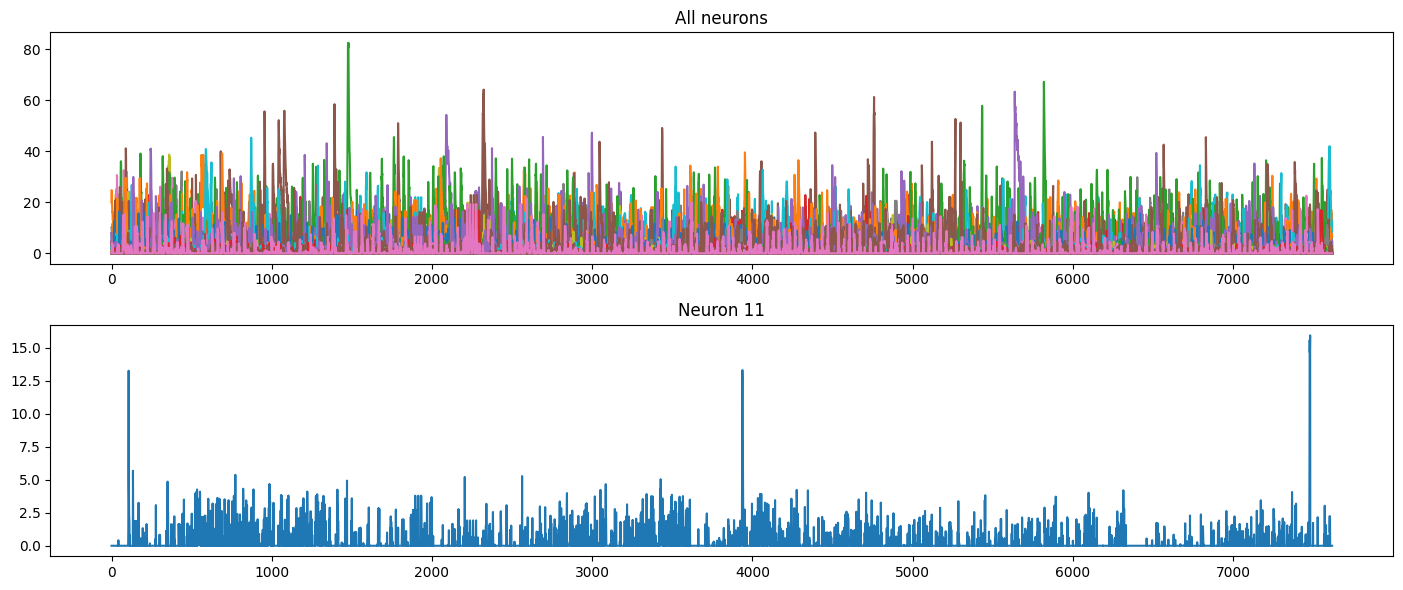

In [407]:
fig, axs = plt.subplots(2, figsize=(14, 6))

# Subfigure 1: All neurons
axs[0].plot(traces[:, :].T)
axs[0].set_title('All neurons')

# Subfigure 2: Neuron 11
axs[1].plot(traces[10, :])
axs[1].set_title('Neuron 11')

plt.tight_layout()
plt.show()

In [23]:
def get_stim_range(u_in):
    one_hot_indices = np.where(u_in == 1)
    gaps = np.where(np.diff(one_hot_indices[1]) > 1)[0]
    gaps_start = one_hot_indices[1][gaps] if gaps.size > 0 else []
    gaps_end = one_hot_indices[1][gaps + 1] if gaps.size > 0 else []
    stim_indices = np.sort(np.concatenate(([0], gaps_start, gaps_end)))
    return stim_indices

stim_indices = get_stim_range(u_in); stim_indices

array([   0,    4,   36,   40,   73,  147,  153,  158,  189,  194,  223,
        228,  260,  264,  297,  301,  336,  368,  372,  406,  410,  439,
        444,  471,  475,  503,  507,  536,  540,  565,  572,  576,  625,
        629,  658,  663,  690,  694,  726,  730,  759,  763,  796,  825,
        830,  860,  865,  893,  897,  926,  930,  961,  965,  995, 1000,
       1027, 1032, 1067, 1071, 1101, 1105, 1143, 1172, 1176, 1206, 1210,
       1239, 1244, 1272, 1277, 1303, 1313, 1343, 1347, 1379, 1383, 1430,
       1434, 1462, 1466, 1511, 1515, 1521, 1525, 1561, 1594, 1598, 1626,
       1631, 1664, 1668, 1699, 1704, 1737, 1742, 1772, 1777, 1833, 1838,
       1866, 1870, 1884, 1888, 1891, 1895, 1903, 1907, 1910, 1914, 1928,
       1932, 1953, 1957, 1985, 1990, 2019, 2023, 2054, 2058, 2089, 2094,
       2122, 2127, 2156, 2160, 2193, 2197, 2206, 2210, 2212, 2217, 2219,
       2223, 2224, 2228, 2230, 2235, 2237, 2241, 2249, 2254, 2256, 2260,
       2275, 2279, 2375, 2379, 2413, 2417, 2444, 24

# Data Preprocessing

Next we will do some further preprocessing to make sure our data is capturing only the most relevant information. We apply Gaussian smoothing, normalization, and downsampling.

In [21]:
from scipy.ndimage import gaussian_filter1d
from skimage.measure import block_reduce

def normalize_traces(traces):
    t = traces / np.max(traces, axis = 1)[:,None]
    t = t - np.mean(t, axis = 1)[:,None]
    return t

In [42]:
SIGMA = 10
DOWNSAMPLING_RATE = 20

In [112]:
traces_smooth = gaussian_filter1d(traces, axis=1, sigma=SIGMA)
traces_norm = normalize_traces(traces_smooth)
traces_reduced = block_reduce(traces_norm, block_size=(1,DOWNSAMPLING_RATE), func=np.mean, cval=np.mean(traces_norm))
u_in_reduced = block_reduce(u_in, block_size=(1,DOWNSAMPLING_RATE), func=np.max)
stim_indices_reduced = get_stim_range(u_in_reduced)

In [114]:
stim_indices_reduced

array([  0,   2,   3,   7,   9,   9,  11,  11,  13,  13,  14,  15,  16,
        18,  18,  20,  20,  21,  22,  23,  23,  25,  27,  28,  31,  31,
        32,  33,  34,  34,  36,  36,  37,  38,  39,  41,  41,  43,  43,
        44,  44,  46,  46,  48,  51,  53,  53,  55,  55,  57,  58,  58,
        60,  60,  61,  63,  65,  65,  67,  67,  68,  69,  71,  71,  73,
        73,  75,  76,  78,  79,  79,  81,  81,  83,  83,  84,  85,  86,
        87,  88,  88,  91,  91,  93,  93,  94,  96,  97,  97,  99,  99,
       100, 101, 102, 102, 104, 104, 106, 106, 107, 108, 109, 110, 111,
       113, 118, 118, 120, 120, 122, 122, 124, 124, 125, 125, 127, 127,
       129, 129, 130, 131, 132, 134, 136, 136, 137, 138, 139, 139, 141,
       141, 142, 143, 144, 144, 146, 146, 148, 148, 149, 150, 151, 152,
       153, 153, 155, 155, 156, 157, 158, 158, 160, 160, 161, 162, 163,
       163, 165, 165, 166, 167, 168, 168, 170, 170, 172, 172, 173, 173,
       175, 175, 177, 177, 178, 179, 180, 180, 182, 182, 183, 18

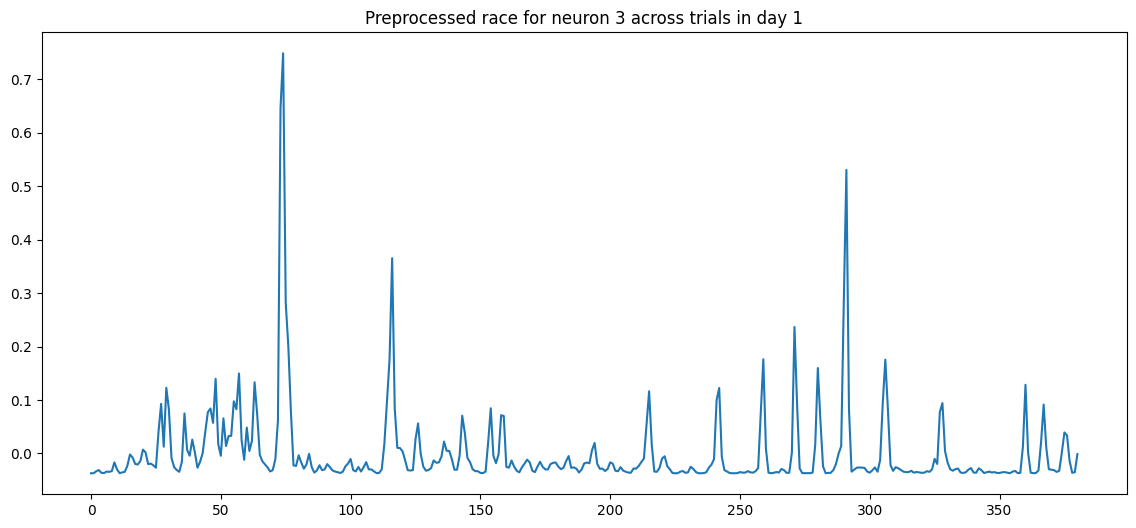

In [408]:
plt.figure(figsize=(14, 6))
plt.plot(traces_reduced[2, :])
plt.title("Preprocessed race for neuron 3 across trials in day 1")
plt.show()

# Preparing all data subsets

#### Phases of the task

* midway through a day
* end of the first day
* end of day 3 (all days concatenated)
* end of last day (all days concatenated)

In [227]:
day0_traces = data[0]['trial_traces']
day0_inputs = data[0]['trial_u_in']

midway0_traces = data[0]['trial_traces'][:, :int(day0_traces.shape[1]/2)]
midway0_inputs = data[0]['trial_u_in'][:, :int(day0_inputs.shape[1]/2)]

day3_traces = np.concatenate([data[i]['trial_traces'] for i in range(3)], axis=1)
day3_inputs = np.concatenate([data[i]['trial_u_in'] for i in range(3)], axis=1)

all_traces = np.concatenate([data[i]['trial_traces'] for i in range(len(data))], axis=1)
all_inputs = np.concatenate([data[i]['trial_u_in'] for i in range(len(data))], axis=1)

phases = {'day_0_midway': (midway0_traces, midway0_inputs), 
          'day_0_end': (day0_traces, day0_inputs), 
          'day_3_midway': (day3_traces, day3_inputs), 
          'all_data': (all_traces, all_inputs)}

In [239]:
def get_stim(u_in):
    """
    Identify the start and end indices of each stimulus period in the input.

    Parameters:
    u_in (np.array): A 2D numpy array with the second dimension representing timesteps.

    Returns:
    stim_ranges (list): A list of tuples, where each tuple contains the start and end indices of a stimulus period.
    """

    stim_ranges = []
    start_idx = None
    end_idx = None
    in_stim = False 

    for t in range(u_in.shape[1]):
        if np.any(u_in[:, t]) and not in_stim:
            start_idx = t
            in_stim = True
        elif not np.any(u_in[:, t]) and in_stim:
            end_idx = t - 1
            in_stim = False
            stim_ranges.append((start_idx, end_idx))

    if in_stim:
        stim_ranges.append((start_idx, u_in.shape[1] - 1))

    return stim_ranges

def preprocess(traces, u_in, SIGMA, DOWNSAMPLING_RATE):
    """
    Preprocess the given traces and inputs.

    Parameters:
    traces (np.array): The neural traces to be preprocessed.
    u_in (np.array): The inputs to be preprocessed.
    SIGMA (float): The standard deviation for the Gaussian kernel.
    DOWNSAMPLING_RATE (int): The rate at which the traces and inputs are to be downsampled.

    Returns:
    traces_reduced (np.array): The downsampled and normalized traces.
    u_in_reduced (np.array): The downsampled inputs.
    stim_ranges (list): The start and end indices of each stimulus period.
    """

    traces_smooth = gaussian_filter1d(traces, axis=1, sigma=SIGMA)
    traces_norm = normalize_traces(traces_smooth)
    traces_reduced = block_reduce(traces_norm, block_size=(1,DOWNSAMPLING_RATE), func=np.mean, cval=np.mean(traces_norm))
    u_in_reduced = block_reduce(u_in, block_size=(1,DOWNSAMPLING_RATE), func=np.max)
    stim_ranges = get_stim(u_in_reduced)

    return traces_reduced, u_in_reduced, stim_ranges

## Model 1: HMM

Our first model for predicting the response neural traces will be a Hidden Markov Model. To keep things simple, we will initially consider an unsupervised learning task on one neuron from our dataset, where the HMM is trained to find the model parameters that best fit the neural traces data and then is used to predict subsequent neural responses.

The subsets of data we will explore here are as follows:

* full day with final response traces witheld for forecasting
* half day with rest of responses witheld for forecasting
* data from one neuron
* data from a subset of X neurons
* data from all neurons
* data from different days

### One neuron

#### Full day

In [220]:
NEURON = 0

num_states = 4
obs_dim = 1 # 1 neuron

NUM_ITERS = 50

In [221]:
neuron = traces_reduced[NEURON, :]
train_df = neuron[:stim_indices_reduced[-1]] # the stimulus lasts approx. 5 frames, the model will train on all the traces up until the last stimulus, will predict the final response

# Reshape the data to a 2D array
obs = np.atleast_2d(train_df).T

/Users/jakub/miniconda3/envs/jax-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
LP: 336.2:   0%|          | 0/50 [00:00<?, ?it/s]

LP: 547.1: 100%|██████████| 50/50 [00:00<00:00, 102.27it/s]


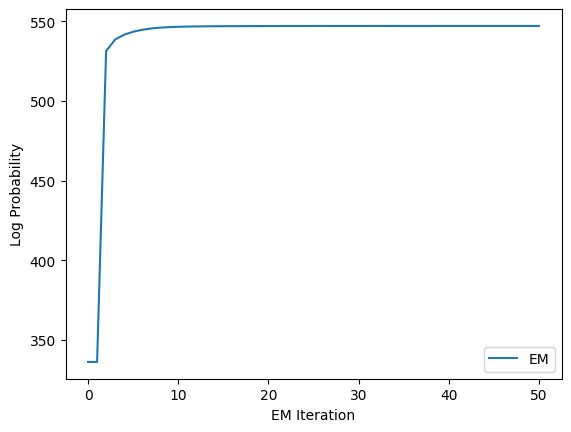

In [222]:
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
hmm_lls = hmm.fit(obs, method="em", num_iters=NUM_ITERS, init_method="kmeans")

plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [223]:
# forecast on the final response
T = neuron.shape[0] - stim_indices_reduced[-1]

hmm_x = hmm.smooth(obs)

pred_state, pred_traces = hmm.sample(T)

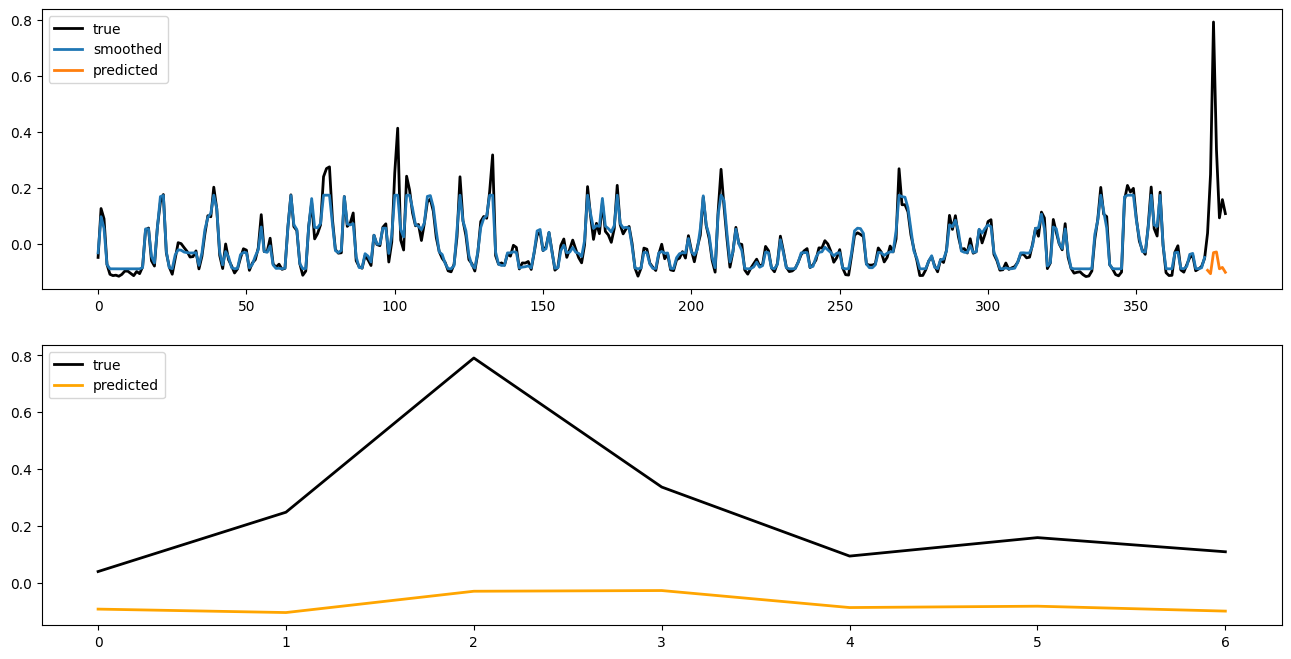

In [225]:
npr.seed(100)
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(neuron, '-k', lw=2, label="true")
plt.plot(hmm_x, '-', lw=2, label="smoothed")
plt.plot(range(len(hmm_x), len(hmm_x) + len(pred_traces)), pred_traces, '-', lw=2, label="predicted")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(neuron[-T:], '-', lw=2, color="black", label="true")
plt.plot(pred_traces, '-', lw=2, color="orange", label="predicted")
plt.legend(loc="upper left")
plt.show()

/Users/jakub/miniconda3/envs/jax-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
LP: 399.3:   0%|          | 0/100 [00:00<?, ?it/s]

LP: 588.6: 100%|██████████| 100/100 [00:01<00:00, 89.76it/s]


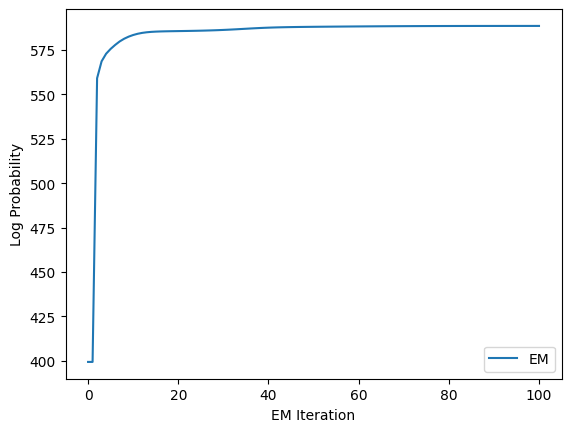

In [205]:
# ARHMM
arhmm = ssm.HMM(num_states, obs_dim, observations="ar", observation_kwargs={'lags': 1})
arhmm_lls = arhmm.fit(obs, method="em", num_ites=NUM_ITERS, init_method="kmeans")

plt.plot(arhmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

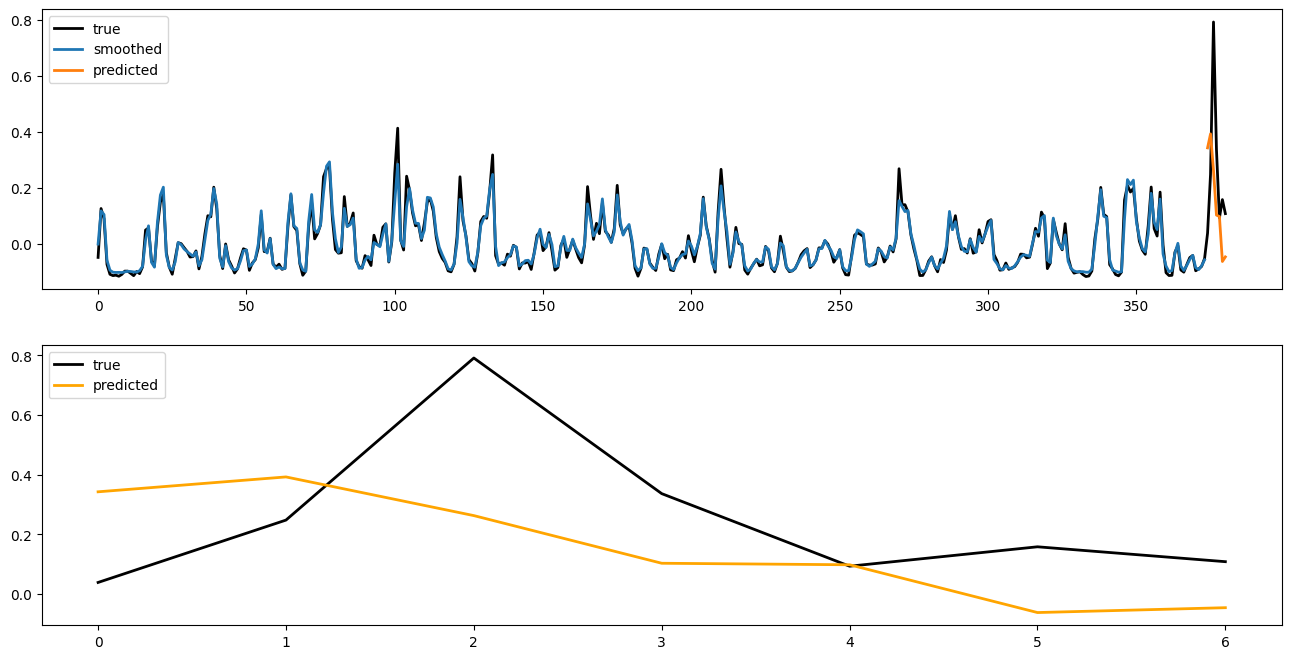

In [218]:
npr.seed(100)
arhmm_x = arhmm.smooth(obs)

pred_state, pred_traces = arhmm.sample(T)
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(neuron, '-k', lw=2, label="true")
plt.plot(arhmm_x, '-', lw=2, label="smoothed")
plt.plot(range(len(arhmm_x), len(arhmm_x) + len(pred_traces)), pred_traces, '-', lw=2, label="predicted")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(neuron[-T:], '-', lw=2, color="black", label="true")
plt.plot(pred_traces, '-', lw=2, color="orange", label="predicted")
plt.legend(loc="upper left")
plt.show()

#### Generalized HMM, ARHMM training

In [317]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import entropy
from numpy import log, mean, var

def train_hmm(model_type, obs, obs_dim, num_states, NUM_ITERS=50, plot=True):

    if model_type == "ar":
        hmm = ssm.HMM(num_states, obs_dim, observations="ar", observation_kwargs={'lags': 1})
    else:
        hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
    hmm_lls = hmm.fit(obs, method="em", num_iters=NUM_ITERS, init_method="kmeans")

    if plot:
        plt.plot(hmm_lls, label="EM")
        plt.xlabel("EM Iteration")
        plt.ylabel("Log Probability")
        plt.legend(loc="lower right")
        plt.show()

    return hmm

def smooth_and_forecast(hmm, true_df, stim_indices, obs, neuron_index=0, plot=True):

    # forecast on the final response
    T = true_df.shape[1] - stim_indices[-1][1]

    hmm_x = hmm.smooth(obs)

    pred_state, pred_traces = hmm.sample(T)

    if plot:
        plt.figure(figsize=(16, 8))
        plt.subplot(2, 1, 1)
        plt.plot(true_df[neuron_index], '-k', lw=2, label="true")
        plt.plot(hmm_x[:, neuron_index], '-', lw=2, label="smoothed")
        plt.plot(range(len(hmm_x), len(hmm_x) + len(pred_traces)), pred_traces[:, neuron_index], '-', lw=2, label="predicted")
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(true_df[neuron_index, -T:], '-', lw=2, color="black", label="true")
        plt.plot(pred_traces[:, neuron_index], '-', lw=2, color="orange", label="predicted")
        plt.legend(loc="upper left")
        plt.show()
    return pred_traces, T

def train_models(num_neurons, num_states, traces, stim_indices, model_type="gaussian", NUM_ITERS=50, padding=0, neuron_index=0, plot=True):

    obs_dim = num_neurons
    true_df = traces[:num_neurons, :]
    train_df = true_df[:, :stim_indices[-1][1] + padding]

    obs = np.atleast_2d(train_df).T # Reshape the data to a 2D array

    hmm = train_hmm(model_type, obs, obs_dim, num_states, NUM_ITERS=50, plot=plot)

    pred_traces, T = smooth_and_forecast(hmm, true_df, stim_indices, obs, neuron_index, plot=plot)

    error = pred_traces.T - true_df[:, -T:]

    mse = mean_squared_error(true_df[:, -T:], pred_traces.T)
    mae = mean_absolute_error(true_df[:, -T:], pred_traces.T)
    r2 = r2_score(true_df[:, -T:], pred_traces.T)

    n = len(obs)
    k = len(hmm.params)
    aic = 2*k - 2*log(mse)
    bic = n*log(mse) + k*log(n)

    return mse, mae, r2, aic, bic


/Users/jakub/miniconda3/envs/jax-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


LP: 207.8: 100%|██████████| 50/50 [00:00<00:00, 112.82it/s]


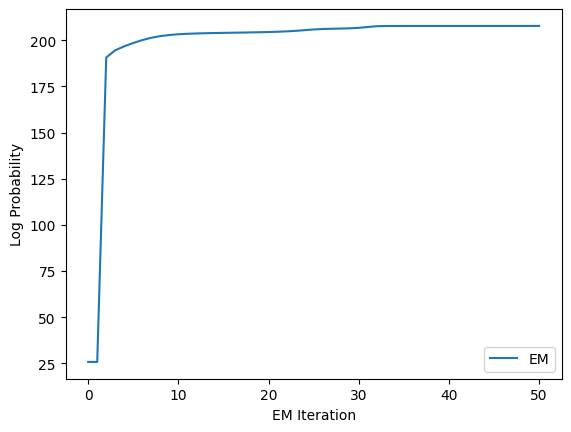

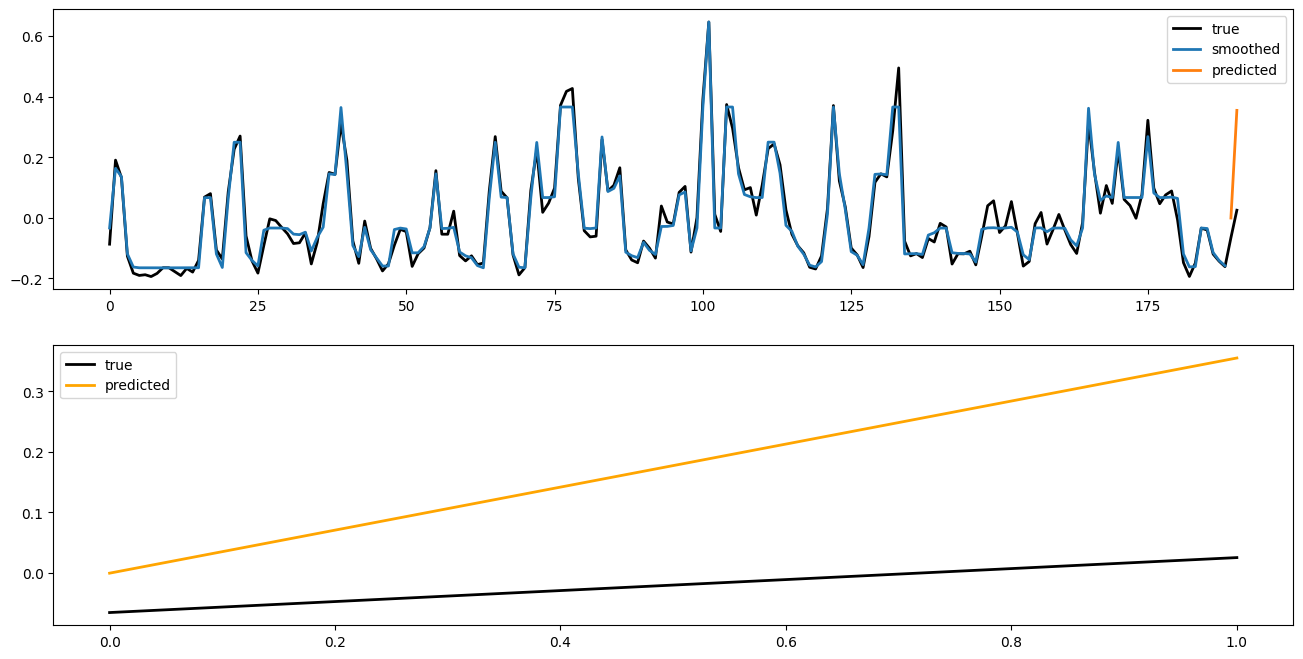

/Users/jakub/miniconda3/envs/jax-env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [312]:
npr.seed(100)

from itertools import product
import pandas as pd

SIGMA = 10
DOWNSAMPLING_RATE = 20
NUM_NEURONS = 1
NUM_STATES = 8
MODEL_TYPE = "gaussian"
PHASE_KEYS = list(phases.keys())


model_results_list = []
traces, inputs = phases[PHASE_KEYS[0]]

traces, inputs, stim_ranges = preprocess(traces, inputs, SIGMA, DOWNSAMPLING_RATE)

# HMM
mse, mae, r2, aic, bic = train_models(NUM_NEURONS, NUM_STATES, traces, stim_ranges, model_type=MODEL_TYPE, neuron_index=0)

# Create a dictionary to store the model parameters and their resulting metrics
model_results = {
    'SIGMA': SIGMA,
    'DOWNSAMPLING_RATE': DOWNSAMPLING_RATE,
    'NUM_NEURONS': NUM_NEURONS,
    'NUM_STATES': NUM_STATES,
    'MODEL_TYPE': MODEL_TYPE,
    'PHASE_KEY': PHASE_KEY,
    'MSE': mse,
    'MAE': mae,
    'R2 Score': r2,
    'AIC': aic,
    'BIC': bic
}

# Append the dictionary to the list
model_results_list.append(model_results)

# Convert the list of dictionaries to a pandas DataFrame and store it
model_results_df = pd.DataFrame(model_results_list)
model_results_df.to_csv('model_results.csv', index=False)

In [ ]:
from tqdm import tqdm

npr.seed(100)

from itertools import product

SIGMA_OPTIONS = [5, 10, 15, 20]
DOWNSAMPLING_RATE_OPTIONS = [10, 20, 30, 40]
NUM_NEURONS_OPTIONS = [1, 4, 50, 156]
NUM_STATES_OPTIONS = [2, 4, 8, 12]
MODEL_TYPE_OPTIONS = ["gaussian", "ar"]
PHASE_KEYS = list(phases.keys())

parameter_combinations = product(SIGMA_OPTIONS, DOWNSAMPLING_RATE_OPTIONS, NUM_NEURONS_OPTIONS, NUM_STATES_OPTIONS, MODEL_TYPE_OPTIONS, PHASE_KEYS)

model_results_list = []
for SIGMA, DOWNSAMPLING_RATE, NUM_NEURONS, NUM_STATES, MODEL_TYPE, PHASE_KEY in tqdm(parameter_combinations):
    traces, inputs = phases[PHASE_KEY]

    traces, inputs, stim_ranges = preprocess(traces, inputs, SIGMA, DOWNSAMPLING_RATE)

    mse, mae, r2, aic, bic = train_models(NUM_NEURONS, NUM_STATES, traces, stim_ranges, model_type=MODEL_TYPE, neuron_index=0, plot=False)

    model_results = {
        'SIGMA': SIGMA,
        'DOWNSAMPLING_RATE': DOWNSAMPLING_RATE,
        'NUM_NEURONS': NUM_NEURONS,
        'NUM_STATES': NUM_STATES,
        'MODEL_TYPE': MODEL_TYPE,
        'PHASE_KEY': PHASE_KEY,
        'MSE': mse,
        'MAE': mae,
        'R2 Score': r2,
        'AIC': aic,
        'BIC': bic
    }

    model_results_list.append(model_results)

In [322]:
# save the trained params
model_results_df = pd.DataFrame(model_results_list)
model_results_df.to_csv('model_results.csv', index=False)

In [300]:
count = 0
for SIGMA, DOWNSAMPLING_RATE, NUM_NEURONS, NUM_STATES, MODEL_TYPE, PHASE_KEY in parameter_combinations:
    count += 1
print(count)

2048


**Possible fix**

Provide the HMM with a few observations leading up to the forecast to make sure our predictions are consistent.

## Model 2: RNN